## WIND SPEED PREDICTION

### This is a regression problem in which we will try to predict wind speed.

### Attribute information

In [ ]:
https://www.kaggle.com/datasets/fedesoriano/wind-speed-prediction-dataset

Loading the dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import klib as k
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import LinearSVR
from fancyimpute import IterativeImputer
import regex as re

### Loading the dataset

In [2]:
data=pd.read_csv('./wind_dataset.csv')
data.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
WIND,6574.0,9.796834,4.977272,0.0,6.0,9.21,12.96,30.37
IND,6574.0,0.391542,1.179092,0.0,0.0,0.00,0.00,4.00
RAIN,6574.0,1.885169,4.030529,0.0,0.0,0.20,2.00,67.00
IND.1,6513.0,0.356364,1.128552,0.0,0.0,0.00,0.00,4.00
T.MAX,5953.0,13.339123,4.890546,-0.1,9.6,13.30,17.20,26.80
IND.2,6513.0,0.464456,1.177571,0.0,0.0,0.00,0.00,4.00
T.MIN,5900.0,6.411678,4.637243,-11.5,3.0,6.50,10.00,18.00
T.MIN.G,6214.0,2.736547,5.569175,-14.4,-1.0,3.00,7.00,15.80


In [5]:
data.shape

(6574, 9)

### Data Processing

#### Renaming the columns

In [6]:
data.rename(columns={'IND':'INDICATOR','IND.1':'INDICATOR_1','T.MAX':'MAX_TEMP','IND.2':'INDICATOR_2','T.MIN':'MIN_TEMP','T.MIN.G':'T_MIN_G'},inplace=True)
data.head()

,DATE,WIND,INDICATOR,RAIN,INDICATOR_1,MAX_TEMP,INDICATOR_2,MIN_TEMP,T_MIN_G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


#### Wind over the years

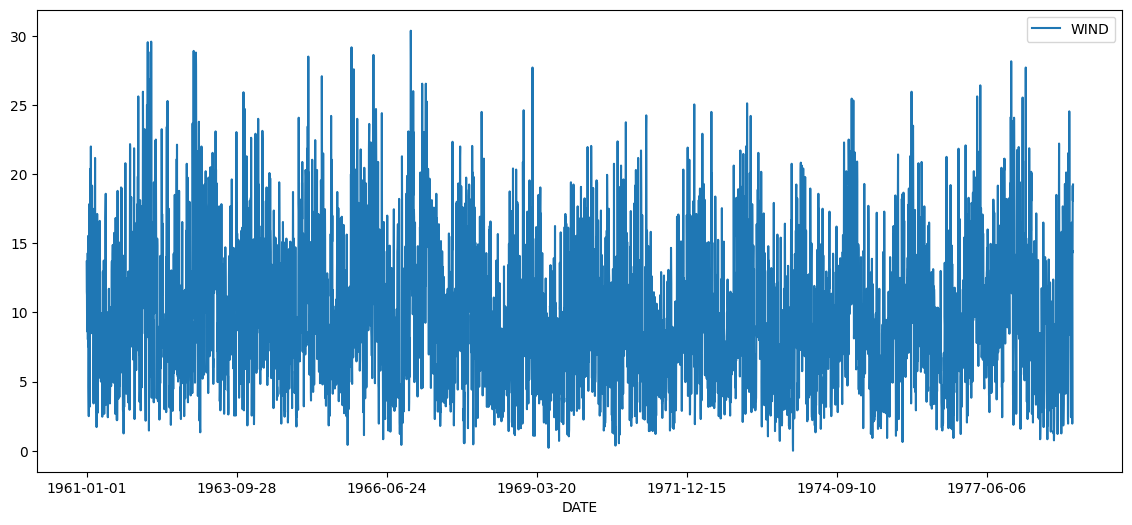

In [7]:
data.plot(x='DATE',y='WIND',figsize=(14,6));

#### Changing the data type of DATE colunm to datetime

In [8]:
data["DATE"] = pd.to_datetime(data.DATE)

#### Extracting day,month and year from the DATE column

In [9]:
data["Day"] = data["DATE"].dt.day
data["Month"] = data["DATE"].dt.month
data["Year"] = data["DATE"].dt.year

#### Lets drop the DATE column

In [10]:
data.drop(columns="DATE", inplace=True)

In [11]:
data.head()

,WIND,INDICATOR,RAIN,INDICATOR_1,MAX_TEMP,INDICATOR_2,MIN_TEMP,T_MIN_G,Day,Month,Year
0,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0,1,1,1961
1,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1,2,1,1961
2,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5,3,1,1961
3,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2,4,1,1961
4,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5,5,1,1961


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   WIND         6574 non-null   float64
 1   INDICATOR    6574 non-null   int64  
 2   RAIN         6574 non-null   float64
 3   INDICATOR_1  6513 non-null   float64
 4   MAX_TEMP     5953 non-null   float64
 5   INDICATOR_2  6513 non-null   float64
 6   MIN_TEMP     5900 non-null   float64
 7   T_MIN_G      6214 non-null   float64
 8   Day          6574 non-null   int64  
 9   Month        6574 non-null   int64  
 10  Year         6574 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 565.1 KB


### DATA VISUALIZATION

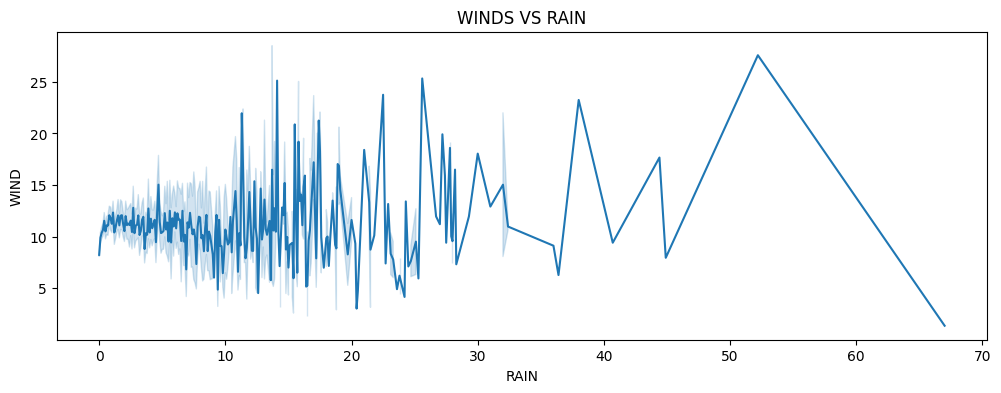

In [13]:
plt.figure(figsize=(12,4))
plt.title("WINDS VS RAIN")
sns.lineplot(data=data,x="RAIN",y="WIND");

#### Null data percentage

In [14]:
null_percentage=data.isnull().mean()*100
null_percentage

WIND            0.000000
INDICATOR       0.000000
RAIN            0.000000
INDICATOR_1     0.927898
MAX_TEMP        9.446304
INDICATOR_2     0.927898
MIN_TEMP       10.252510
T_MIN_G         5.476118
Day             0.000000
Month           0.000000
Year            0.000000
dtype: float64

#### Impute the missing data using Iterative imputer

In [15]:
data_mice = data.copy(deep=True)

In [16]:
mice = IterativeImputer()

In [17]:
data_mice.iloc[:,:] = mice.fit_transform(data_mice)


In [18]:
data_mice.isnull().sum()

WIND           0
INDICATOR      0
RAIN           0
INDICATOR_1    0
MAX_TEMP       0
INDICATOR_2    0
MIN_TEMP       0
T_MIN_G        0
Day            0
Month          0
Year           0
dtype: int64

In [19]:
data_mice.sample(10)

,WIND,INDICATOR,RAIN,INDICATOR_1,MAX_TEMP,INDICATOR_2,MIN_TEMP,T_MIN_G,Day,Month,Year
3164,4.12,0.0,0.0,0.0,16.8,0.0,8.2,4.077139,31.0,8.0,1969.0
3730,19.08,0.0,0.2,0.0,5.8,0.0,3.0,1.800000,20.0,3.0,1971.0
4570,4.33,0.0,0.0,0.0,18.7,0.0,6.9,1.500000,7.0,7.0,1973.0
4727,10.88,4.0,0.0,0.0,7.6,0.0,2.3,-1.000000,11.0,12.0,1973.0
693,4.00,0.0,0.0,0.0,10.0,0.0,5.1,1.600000,25.0,11.0,1962.0
4000,15.37,4.0,0.0,0.0,10.8,0.0,9.0,5.400000,15.0,12.0,1971.0
4237,14.12,1.0,4.0,0.0,16.7,0.0,14.0,10.900000,8.0,8.0,1972.0
495,11.04,0.0,1.6,0.0,14.0,0.0,6.2,3.100000,11.0,5.0,1962.0
6201,21.75,0.0,0.4,0.0,9.9,0.0,7.7,2.400000,24.0,12.0,1977.0
5585,9.42,0.0,0.0,0.0,14.2,0.0,9.6,8.200000,17.0,4.0,1976.0


In [20]:
data.head(10)

,WIND,INDICATOR,RAIN,INDICATOR_1,MAX_TEMP,INDICATOR_2,MIN_TEMP,T_MIN_G,Day,Month,Year
0,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0,1,1,1961
1,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1,2,1,1961
2,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5,3,1,1961
3,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2,4,1,1961
4,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5,5,1,1961
5,10.67,0,0.0,0.0,6.5,0.0,1.2,-2.0,6,1,1961
6,9.17,0,1.9,0.0,9.2,1.0,-2.4,-7.1,7,1,1961
7,14.29,0,0.0,0.0,6.6,0.0,3.1,0.0,8,1,1961
8,8.04,0,8.3,0.0,6.8,0.0,2.4,-0.8,9,1,1961
9,11.42,0,0.0,0.0,6.5,0.0,3.0,0.5,10,1,1961


#### After the imputation some column data types are changed. Lets change it back to normal.

In [21]:
data_mice["INDICATOR"] = data_mice["INDICATOR"].astype("int")
data_mice["Month"] = data_mice["Month"].astype("int")
data_mice["Day"] = data_mice["Day"].astype("int")
data_mice["Year"] = data_mice["Year"].astype("int")

In [22]:
data_mice.head()

,WIND,INDICATOR,RAIN,INDICATOR_1,MAX_TEMP,INDICATOR_2,MIN_TEMP,T_MIN_G,Day,Month,Year
0,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0,1,1,1961
1,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1,2,1,1961
2,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5,3,1,1961
3,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2,4,1,1961
4,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5,5,1,1961


### Checking outliers

#### Box plot

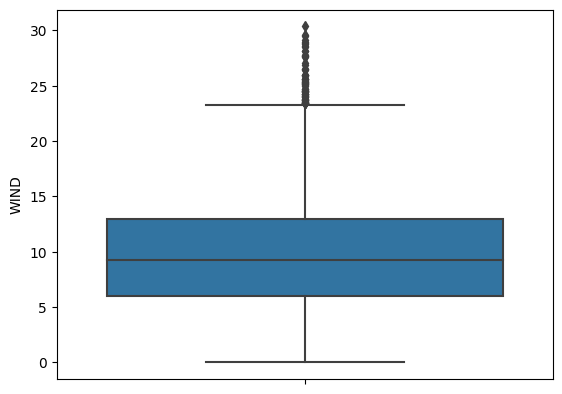

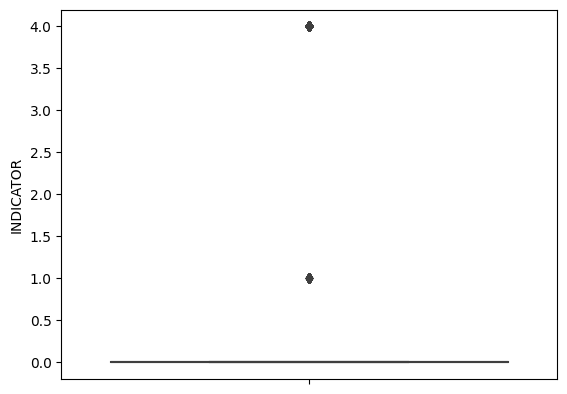

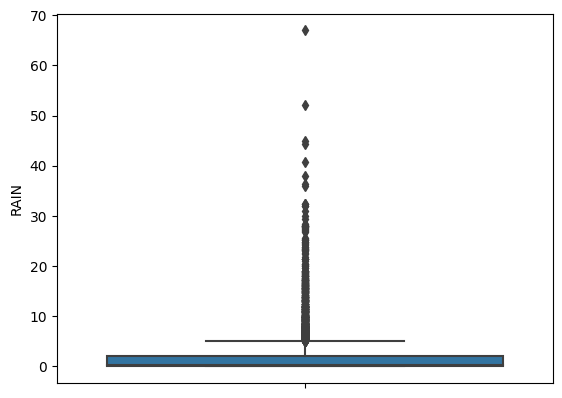

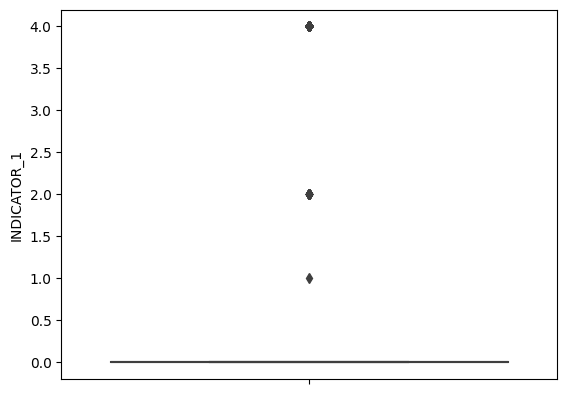

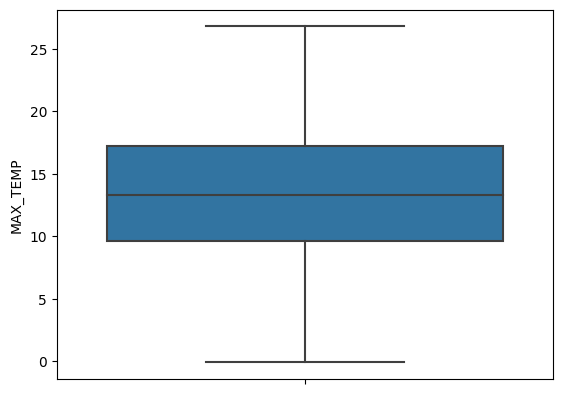

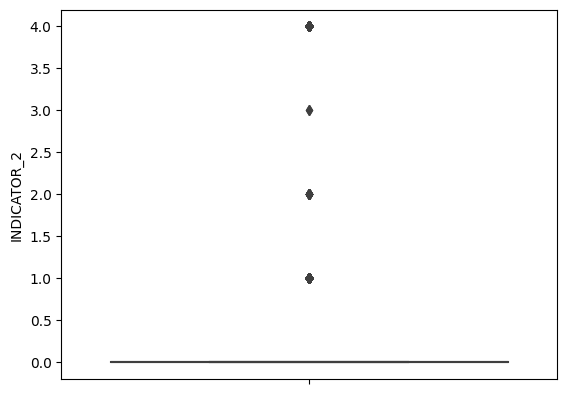

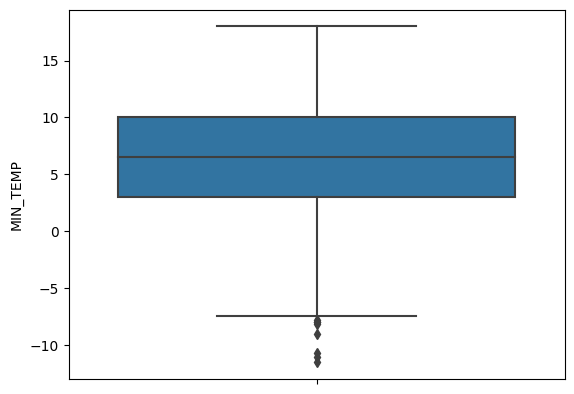

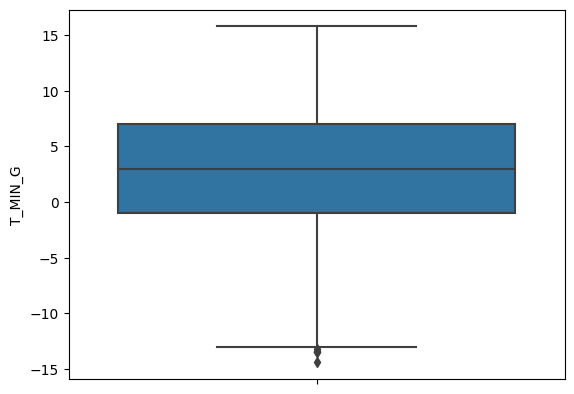

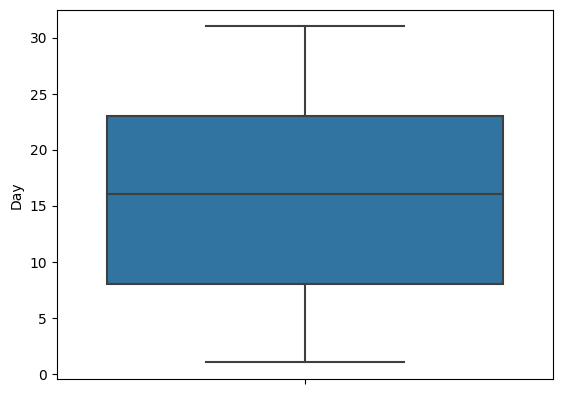

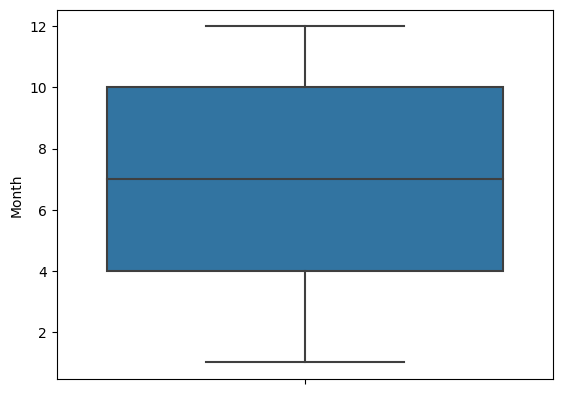

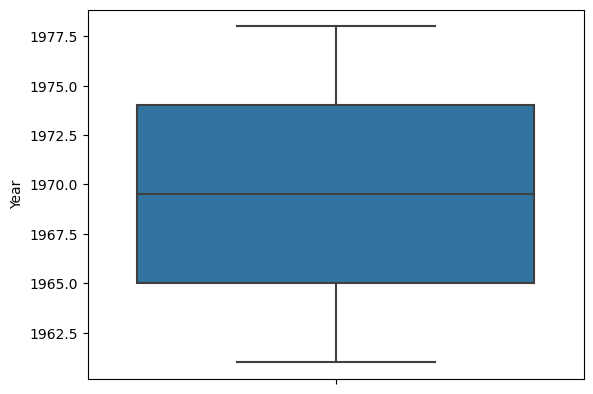

In [23]:
for i in data_mice.columns:
    sns.boxplot(y=data[i])
    plt.show();



#### Setting the outlier limits 



In [24]:
def outlier_limt(col):
    Q3,Q1 = np.nanpercentile(col, [75,25])
    IQR = Q3 - Q1
    UL = Q3+1.5*IQR
    LL = Q1-1.5*IQR
    return UL, LL

In [25]:
for i in data_mice.columns:
    UL, LL = outlier_limt(data_mice[i])
    data_mice[i] = np.where((data_mice[i]>UL)|(data_mice[i]<LL), np.nan, data[i])

In [26]:
data_mice.isnull().sum()

WIND             66
INDICATOR       681
RAIN            740
INDICATOR_1     662
MAX_TEMP        621
INDICATOR_2    1222
MIN_TEMP        678
T_MIN_G         367
Day               0
Month             0
Year              0
dtype: int64

In [27]:
data_mice.isnull().mean()*100

WIND            1.003955
INDICATOR      10.358990
RAIN           11.256465
INDICATOR_1    10.069973
MAX_TEMP        9.446304
INDICATOR_2    18.588378
MIN_TEMP       10.313356
T_MIN_G         5.582598
Day             0.000000
Month           0.000000
Year            0.000000
dtype: float64

In [28]:
data_mice.dropna(inplace=True)

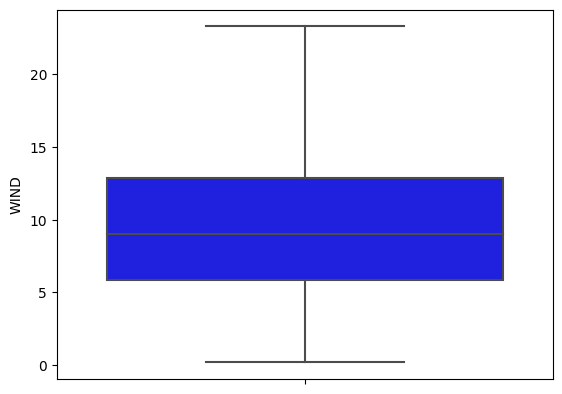

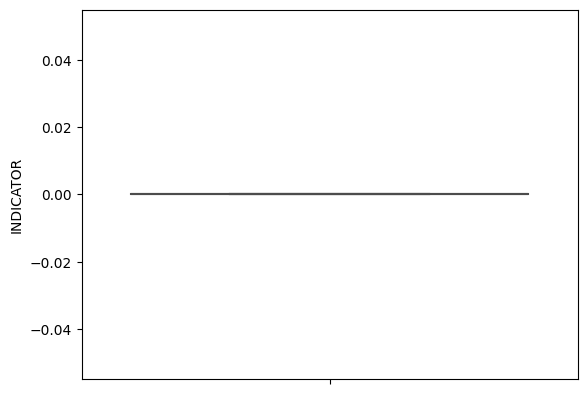

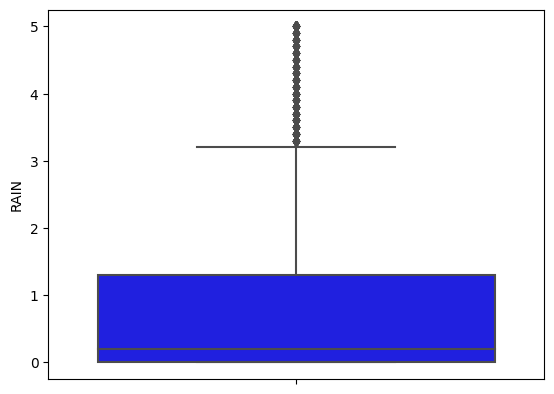

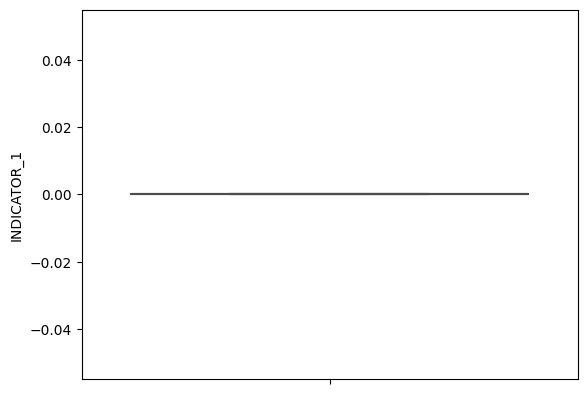

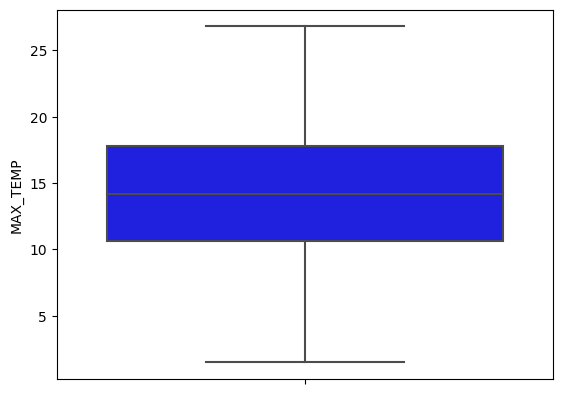

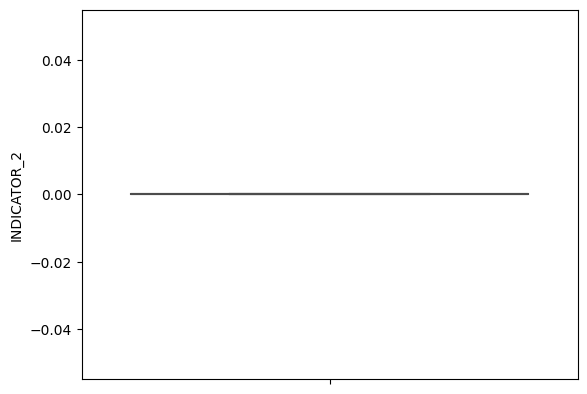

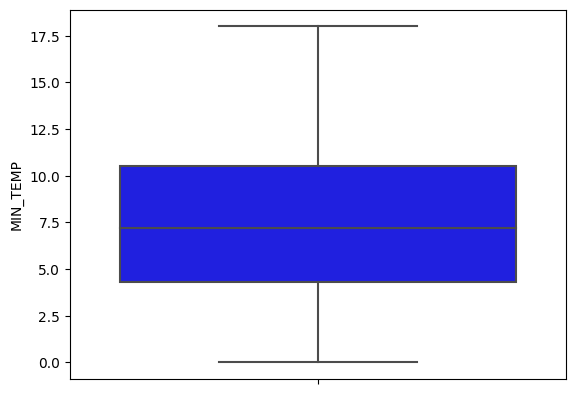

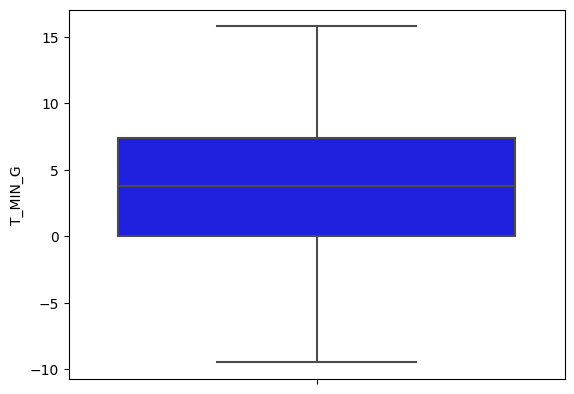

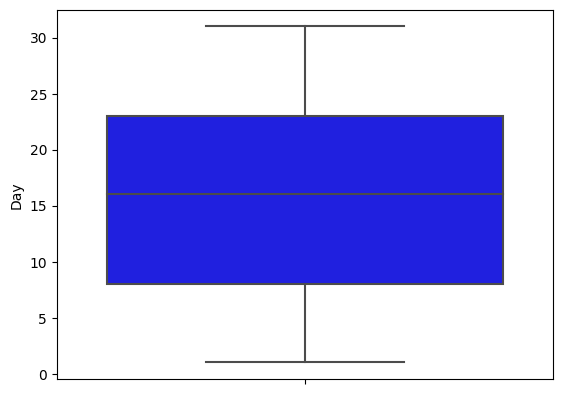

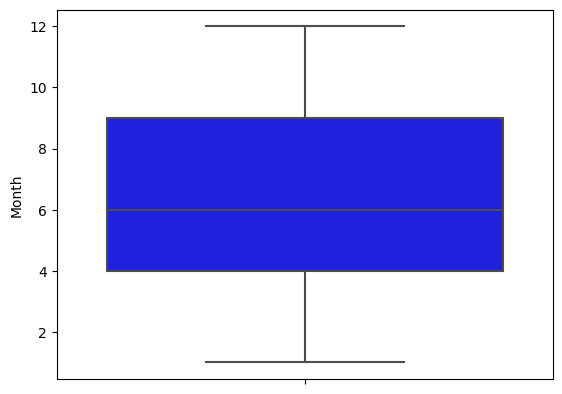

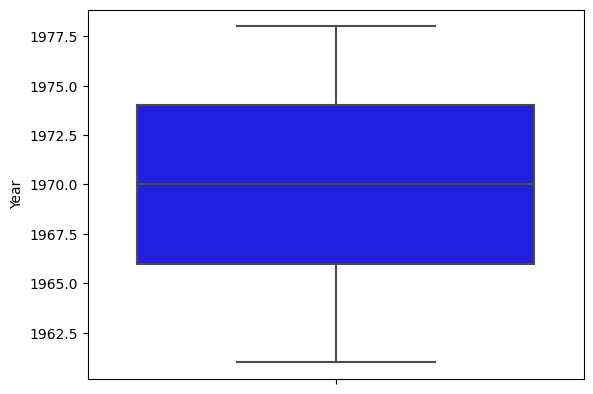

In [29]:
for i in data_mice.columns:
    sns.boxplot(y=data_mice[i], color="blue")
    plt.show();

In [30]:
data_mice.shape

(3979, 11)

In [31]:
data.shape

(6574, 11)

### Histogram

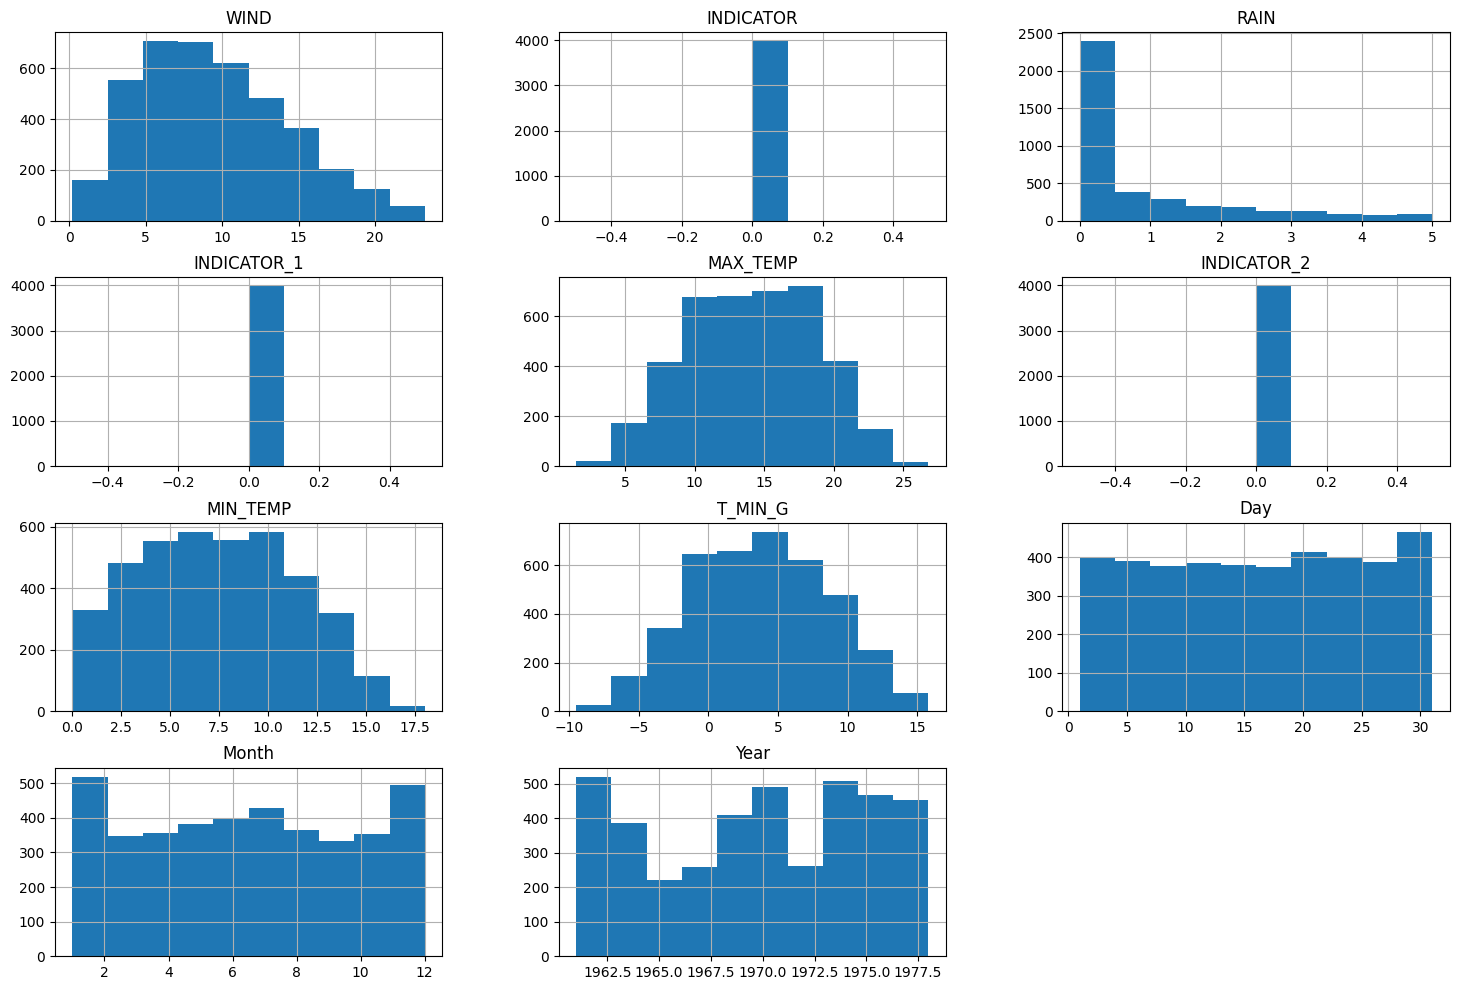

In [32]:
data_mice.hist(figsize=(18,12));

### Correlation matrix

<AxesSubplot: >

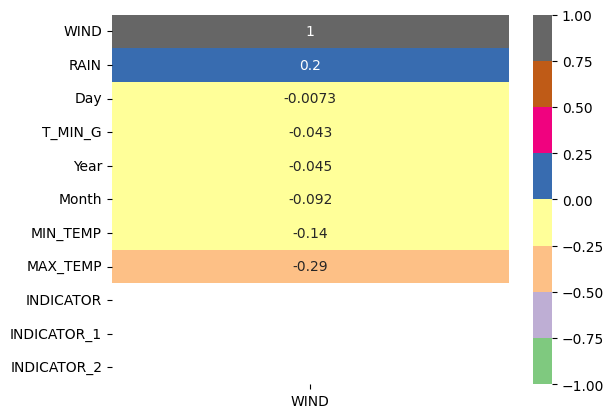

In [33]:
sns.heatmap(data_mice.corr()[["WIND"]].sort_values(by="WIND", ascending=False), vmax=1, vmin=-1, annot=True, cmap="Accent")

We can see that only RAIN is are positively correlated to WIND

### Features into x and y

In [34]:
x = data_mice.drop(["WIND"], axis=1).values
y = data_mice["WIND"].values

In [35]:
sc = StandardScaler()

In [36]:
x = sc.fit_transform(x)

### Splitting into training and testing

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

## Model building

In [38]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "LinearSVR":LinearSVR(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    "GradientBoostingRegressor":GradientBoostingRegressor(),
    "AdaBoostRegressor":AdaBoostRegressor(),
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

In [39]:
for name, model in models.items():
    model.fit(x_train, y_train)
    print("model trained with {}".format(name))
    training_score = model.score(x_train, y_train)*100
    testing_score = model.score(x_test, y_test)*100
    score = r2_score(y_test, model.predict(x_test))*100
    mae = mean_absolute_error(y_test, model.predict(x_test))
    mse = mean_squared_error(y_test, model.predict(x_test))
    rmse = np.sqrt(mse)
    print("r2score: ",score)
    print("training_score: ", training_score)
    print("testing_score: ", testing_score)
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse_test: ", rmse)
    print("*"*100)

model trained with LinearRegression
r2score:  14.048928465628075
training_score:  14.578886305432825
testing_score:  14.048928465628075
mae:  3.493303647556664
mse:  18.854434148885552
rmse_test:  4.34216929067552
****************************************************************************************************
model trained with Ridge
r2score:  14.049341506281898
training_score:  14.578881344572302
testing_score:  14.049341506281898
mae:  3.493342471939071
mse:  18.854343543292515
rmse_test:  4.342158857445512
****************************************************************************************************
model trained with LinearSVR
r2score:  13.056634872286576
training_score:  13.65387666279898
testing_score:  13.056634872286576
mae:  3.4713460762430057
mse:  19.072106062429253
rmse_test:  4.367162243657688
****************************************************************************************************
model trained with DecisionTreeRegressor
r2score:  -58.777247917964395


#### GradientBoostingRegressor is having the best perfomance. Lets use it to predict wind speed.

In [40]:
GBR = GradientBoostingRegressor(random_state=0)

In [41]:
GBR.fit(x_train, y_train)

GradientBoostingRegressor(random_state=0)

In [42]:
y_pred = GBR.predict(x_test)

In [47]:
OUTPUT = pd.DataFrame(zip(y,y_pred), columns=("ACTUAL", "PREDICTED"),dtype=float)
OUTPUT.head()

,ACTUAL,PREDICTED
0,13.67,7.923410
1,11.25,8.933925
2,8.63,10.024095
3,10.67,9.854089
4,14.29,9.910549
